In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [16]:
df = pd.read_csv('train.csv') 

# 1- EDA


In [17]:
df = df[[
        'id', 'target', 'comment_text', 
        # 'severe_toxicity', 'obscene','identity_attack', 'insult', 'threat', 'sexual_explicit',
        # 'asian', 'atheist', 'bisexual','buddhist', 'heterosexual', 'hindu','intellectual_or_learning_disability',
        # 'latino','other_disability','other_gender', 'other_race_or_ethnicity', 'other_religion',
        # 'other_sexual_orientation', 'physical_disability','transgender', 
       'black', 'white',
       'female', 'male',
       'jewish', 'christian', 'muslim',
       'homosexual_gay_or_lesbian', 
       'psychiatric_or_mental_illness', 
        #
       'created_date','publication_id', 'parent_id', 'article_id',
        # 
       'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 
       'identity_annotator_count', 'toxicity_annotator_count']]

In [18]:
df.shape

(1804874, 24)

In [19]:
df.dtypes

id                                 int64
target                           float64
comment_text                      object
black                            float64
white                            float64
female                           float64
male                             float64
jewish                           float64
christian                        float64
muslim                           float64
homosexual_gay_or_lesbian        float64
psychiatric_or_mental_illness    float64
created_date                      object
publication_id                     int64
parent_id                        float64
article_id                         int64
rating                            object
funny                              int64
wow                                int64
sad                                int64
likes                              int64
disagree                           int64
identity_annotator_count           int64
toxicity_annotator_count           int64
dtype: object

### Adapt columns

In [20]:
# Created_date converted to date format
df['created_date'] = pd.to_datetime(df['created_date']).dt.date
# Rating converted to binary
bin = {'rejected' : 0,'approved' : 1}
df['rating'] = df['rating'].map(bin)


### Correlation

C:\Users\PC\AppData\Local\Temp\ipykernel_14260\732031690.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr= df.corr()


<AxesSubplot: >

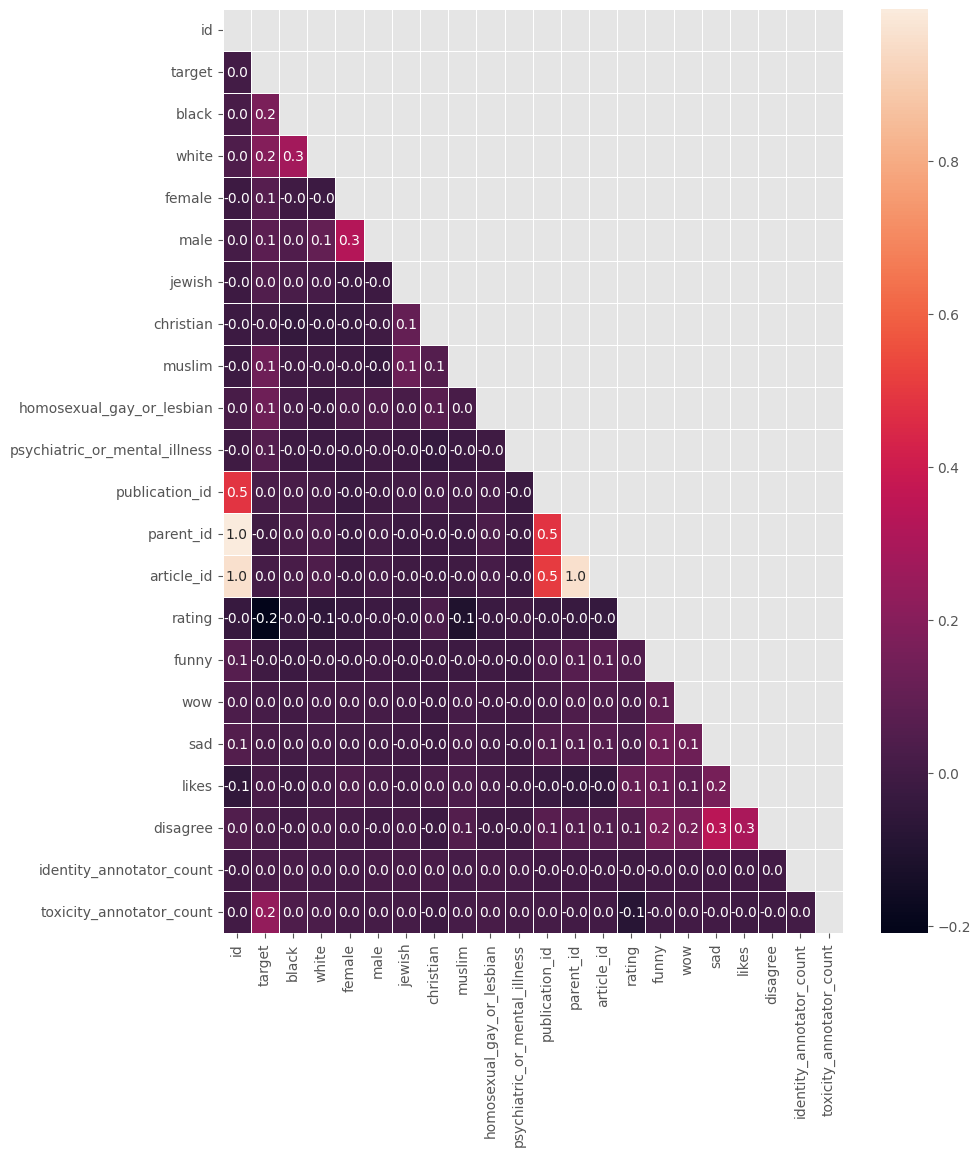

In [21]:
corr= df.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# using the upper triangle matrix as mask 
fig, ax = plt.subplots(figsize=(10,12))        
sns.heatmap(corr, annot=True, mask=matrix, linewidth=.5, fmt=".1f")

### Dependant variable distribution

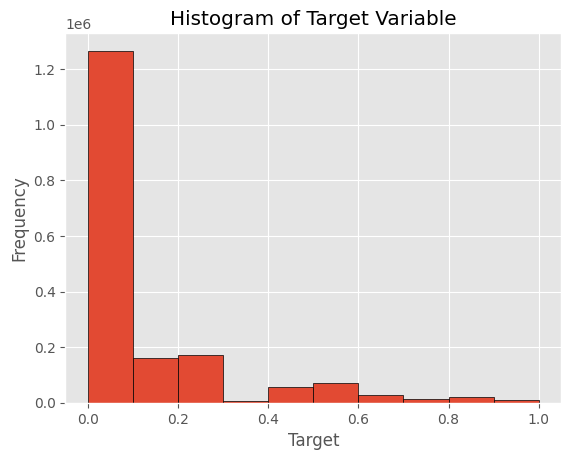

In [110]:

# Plot histogram of the 'target' variable
plt.hist(df['target'], bins=10, edgecolor='black')

# Set the labels and title
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Histogram of Target Variable')

# Display the histogram
plt.show()

# 2- Data scrubbing


In [22]:
df.isna().sum()

id                                     0
target                                 0
comment_text                           0
black                            1399744
white                            1399744
female                           1399744
male                             1399744
jewish                           1399744
christian                        1399744
muslim                           1399744
homosexual_gay_or_lesbian        1399744
psychiatric_or_mental_illness    1399744
created_date                           0
publication_id                         0
parent_id                         778646
article_id                             0
rating                                 0
funny                                  0
wow                                    0
sad                                    0
likes                                  0
disagree                               0
identity_annotator_count               0
toxicity_annotator_count               0
dtype: int64

These columns have null values in the same rows

In [23]:
# check which rows have null values in all three columns
null_rows = df[['black', 'white',
       'female', 'male',
       'jewish', 'christian', 'muslim',
       'homosexual_gay_or_lesbian', 
       'psychiatric_or_mental_illness', ]].isnull().all(axis=1)

# print the count of null o rows
print(null_rows.sum())


1399744


In [24]:
# check which rows have null values in the specified columns and zeros in 'funny', 'wow', 'sad', 'likes' columns
null_rows = df[['black', 'white',
       'female', 'male',
       'jewish', 'christian', 'muslim',
       'homosexual_gay_or_lesbian', 
       'psychiatric_or_mental_illness', ]].isnull().all(axis=1) & \
            (df[['funny', 'wow', 'sad', 'likes']] == 0).all(axis=1)

# print the count of null and zero rows
print(null_rows.sum())

493421


# 3- Pre-prosessing


In [25]:
df = df.drop(columns=['black', 'white',
       'female', 'male',
       'jewish', 'christian', 'muslim',
       'homosexual_gay_or_lesbian', 
       'psychiatric_or_mental_illness',
       'created_date', 'publication_id','parent_id', 'article_id',
       # 'rating', 'funny', 'wow', 'sad',
       # 'likes', 'disagree', 'identity_annotator_count',
       # 'toxicity_annotator_count'
       ])

### Remove stop words, punctiation and lemmatize

In [27]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # remove non-alphabetic characters, tokenize, remove stopwords, and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in nltk.word_tokenize(re.sub('[^a-zA-Z0-9_*:\(\)@]', ' ', text)) if token not in stop_words]
    return tokens

# apply the preprocessing function to the comment_text column
df['comment_text'] = df['comment_text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Doc2Vec model

In [30]:
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(df[['comment_text', 'rating', 'funny', 'wow', 'sad','likes', 'disagree', 'identity_annotator_count','toxicity_annotator_count']], df['target'], test_size=0.3, random_state=42)

# Tag documents for Doc2Vec
tagged_data_train = [TaggedDocument(words=comment, tags=[index]) for index, comment in enumerate(X_train['comment_text'])]

# Train Doc2Vec model
model = Doc2Vec(min_count=1)
model.build_vocab(tagged_data_train)
model.train(tagged_data_train, total_examples=model.corpus_count, epochs=model.epochs)

# Get document vectors for train, validation, and test sets
train_vectors = [model.infer_vector(doc_words=doc.words) for doc in tagged_data_train]
test_vectors = [model.infer_vector(doc_words=doc.words) for doc in [TaggedDocument(words=comment, tags=[index]) for index, comment in enumerate(X_test['comment_text'])]]

# Convert document vectors to pandas dataframes
df_train_vec = pd.DataFrame(train_vectors, columns=[f'doc2vec_{i}' for i in range(100)])
df_test_vec = pd.DataFrame(test_vectors, columns=[f'doc2vec_{i}' for i in range(100)])

In [61]:
# Concatenate train and test dataframes with Doc2Vec vectors
X_train = pd.concat([X_train.reset_index(drop=True), df_train_vec], axis=1).drop(columns=['comment_text'])
X_test = pd.concat([X_test.reset_index(drop=True), df_test_vec], axis=1).drop(columns=['comment_text'])

# 3- Classification

### Training

In [63]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=7, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=7, random_state=42)

### Testing

In [90]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on the test set
y_test_pred = regr.predict(X_test)
y_train_pred = regr.predict(X_train)

In [91]:
# Calculate mean absolute error (MAE) -Train
mae_train = mean_absolute_error(y_train, y_train_pred)
print("Training error, MAE:", mae_train)

Training error, MAE: 0.01857342236968471


In [92]:
# Calculate mean absolute error (MAE) - Test
mae_test = mean_absolute_error(y_test, y_test_pred)
print("Generalization error, MAE:", mae_test)

Generalization error, MAE: 0.047391483848417175


In [105]:
# Calculate R-squared (R2) - Train
r2_train = r2_score(y_train, y_train_pred)
print("R2 score :", r2_train)

R2 score : 0.9396491131148348


In [106]:
# Calculate mean squared error (MSE) - Train
mse_train = mean_squared_error(y_train, y_train_pred)
print("Training error, MSE:",mse_train)

Training error, MSE: 0.002337527631262084


In [107]:
# Calculate mean squared error (MSE) - test
mse_test = mean_squared_error(y_test, y_test_pred)
print("Generalization error, MSE:",mse_test)

Generalization error, MSE: 0.011964869076844556


In [99]:
# Convert continuous to binary using threshold
y_test_pred_binary = [1 if x > 0.5 else 0 for x in y_test_pred]
y_test_binary = [1 if x > 0.5 else 0 for x in y_test]

y_train_pred_binary = [1 if x > 0.5 else 0 for x in y_train_pred]
y_train_binary = [1 if x > 0.5 else 0 for x in y_train]

In [108]:
# Calculate train accuracy score binary
accuracy_binary_training = accuracy_score(y_train_binary, y_train_pred_binary)
print("Training Accuracy binary:", accuracy_binary_training)

Training Accuracy binary: 0.9863852697182469


In [109]:
# Calculate train accuracy score binary
accuracy_binary_test = accuracy_score(y_test_binary, y_test_pred_binary)
print("Generalization Accuracy binary:", accuracy_binary_test)

Generalization Accuracy binary: 0.9555832993205445


# 4- Limitations

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid to search over
# param_grid = {
#     'n_estimators': [5, 10, 15,20, 50],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [350,750,1500, 15000],
#     'min_samples_leaf': [100, 500,1000,10000]
# }

# # Create the random forest regressor
# rf = RandomForestRegressor()

# # Create the GridSearchCV object
# grid_search = GridSearchCV(
#     rf, 
#     param_grid, 
#     cv=5, 
#     scoring='neg_mean_squared_error',
#     n_jobs=-1
# )

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best parameters and the corresponding score
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", -grid_search.best_score_)